In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import rfft
import statsmodels.api as sm

In [3]:
train = pd.read_parquet('train.parquet')

In [4]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [5]:
print("Пропуски:")
print(train.isnull().sum())

Пропуски:
id        0
dates     0
values    0
label     0
dtype: int64


In [6]:
def extract_statistics(series):
    return {
        'mean': np.mean(series),
        'std': np.std(series),
        'median': np.median(series),
        'min': np.min(series),
        'max': np.max(series),
        'trend': np.polyfit(np.arange(len(series)), series, 1)[0],
        'num_outliers': np.sum(np.abs((series - np.mean(series)) / np.std(series)) > 3)
    }

stats = train['values'].apply(extract_statistics).apply(pd.Series)
train = pd.concat([train, stats], axis=1)

In [7]:
train_exploded = train.explode('dates')
train_exploded['dates'] = pd.to_datetime(train_exploded['dates'])

train_exploded['day_of_week'] = train_exploded['dates'].dt.dayofweek
train_exploded['month'] = train_exploded['dates'].dt.month
train_exploded['year'] = train_exploded['dates'].dt.year

In [8]:
def fourier_transform(series):
    fft_result = rfft(series)
    return np.abs(fft_result)

train['fft'] = train['values'].apply(fourier_transform)

In [9]:
def autocorrelation_features(series, lags=5):
    return [sm.tsa.stattools.acf(series, nlags=lags)[i] for i in range(1, lags + 1)]

autocorr = train['values'].apply(autocorrelation_features)
autocorr_df = pd.DataFrame(autocorr.tolist(), columns=[f'autocorr_lag_{i}' for i in range(1, 6)])
train = pd.concat([train, autocorr_df], axis=1)

In [14]:
print(train['values'].isnull().sum())

0


In [22]:
expanded_values = pd.DataFrame(train['values'].tolist()).melt()
train['values'] = expanded_values['value'].astype(float)

mean_value = train['values'].mean()
std_value = train['values'].std()

if std_value != 0:
    z_scores = (train['values'] - mean_value) / std_value
    outliers = np.abs(z_scores) > 3
    train.loc[outliers, 'values'] = np.nan
    train['values'] = train['values'].fillna(mean_value)
else:
    print("Все значения одинаковые.")

print(train['values'].describe())

count    80000.00000
mean         0.43975
std          1.37931
min         -3.70000
25%         -0.52000
50%          0.44000
75%          1.40000
max          4.58000
Name: values, dtype: float64


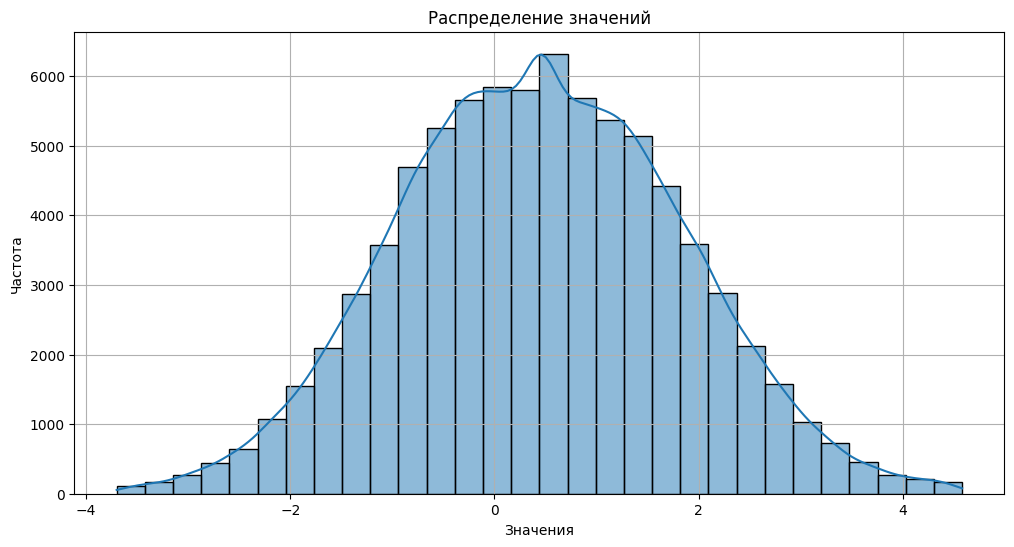

In [23]:
plt.figure(figsize=(12, 6))
sns.histplot(train['values'], bins=30, kde=True)
plt.title('Распределение значений')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [21]:
print(train.head())
print(train.describe())

      id                                              dates  values  label  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   -1.86    0.0   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   -1.04    1.0   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...    0.28    0.0   
3  66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   -0.33    0.0   
4   2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...    1.31    0.0   

       mean       std    median       min   max     trend  num_outliers  \
0  0.023710  1.337272 -0.110000 -4.840000  3.49 -0.011222           1.0   
1 -0.310777  1.556337 -0.274409 -3.534409  2.92 -0.026755           0.0   
2 -0.046042  1.065023 -0.145000 -1.950000  2.61 -0.032482           0.0   
3 -0.130000  1.158201 -0.345000 -2.220000  2.49  0.049298           0.0   
4 -0.270536  1.270529 -0.475000 -2.500000  2.87 -0.011478           0.0   

                                                 fft  autocorr_lag_1  \
0  [1.46